Read a cam climatology, + climatological obs and plot.
Adapted from Andrew Gettelman

In [72]:
# Packages
import numpy as np
import scipy.io.netcdf as S
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from scipy import interpolate
import mpl_toolkits.basemap as bm
import xarray as xr
import esmlab
import seaborn as sns
# import matplotlib_inline.backend_inline

plt.rcParams['figure.figsize'] = [10, 10]
# matplotlib_inline.backend_inline.set_matplotlib_formats('png', 'pdf')
# set_matplotlib_formats('png', 'pdf')

### Read CloudSat Observations
Data from Matt Christensen

In [73]:
#get CloudSat Observations
cspth='/glade/work/andrew/CloudSat/cloudsat_precip_l3/'
csfn='cloudsat_precip_L3_v_0.01_100.nc'

dcs=xr.open_dataset(cspth+csfn)
zmrr=dcs.precip_rate_frequency.mean(dim='nlon')

In [74]:
# Model data

pth='/glade/derecho/scratch/wchuang/archive/'

cases=['run12_kk2000_12month_rerun',
       'run12_tau_12month_rerun2',
       'run12_1nn_optimized_12month_rerun2',
       'run12_3nn_add_CLD_lev_FREQR_12month_proper_rerun2',
      ]

ftyp='*h0*'

cstxt=['Control',
       'TAU',
       'TAU 1nn',
       'TAU 3nn',
      ]

tmp = [pth + s for s in cases]
fspec = [s + '/atm/hist/'+ftyp for s in tmp]
# 
nr=len(cases)
#fspec[0]
#print(fspec[r]+'*.SWCF.*')
fspec

['/glade/derecho/scratch/wchuang/archive/run12_kk2000_12month_rerun/atm/hist/*h0*',
 '/glade/derecho/scratch/wchuang/archive/run12_tau_12month_rerun2/atm/hist/*h0*',
 '/glade/derecho/scratch/wchuang/archive/run12_1nn_optimized_12month_rerun2/atm/hist/*h0*',
 '/glade/derecho/scratch/wchuang/archive/run12_3nn_add_CLD_lev_FREQR_12month_proper_rerun/atm/hist/*h0*']

### Plot FREQR near the surface (level 31)

Note That Obs from CloudSat are ocean only, so need to sort by land mask first....

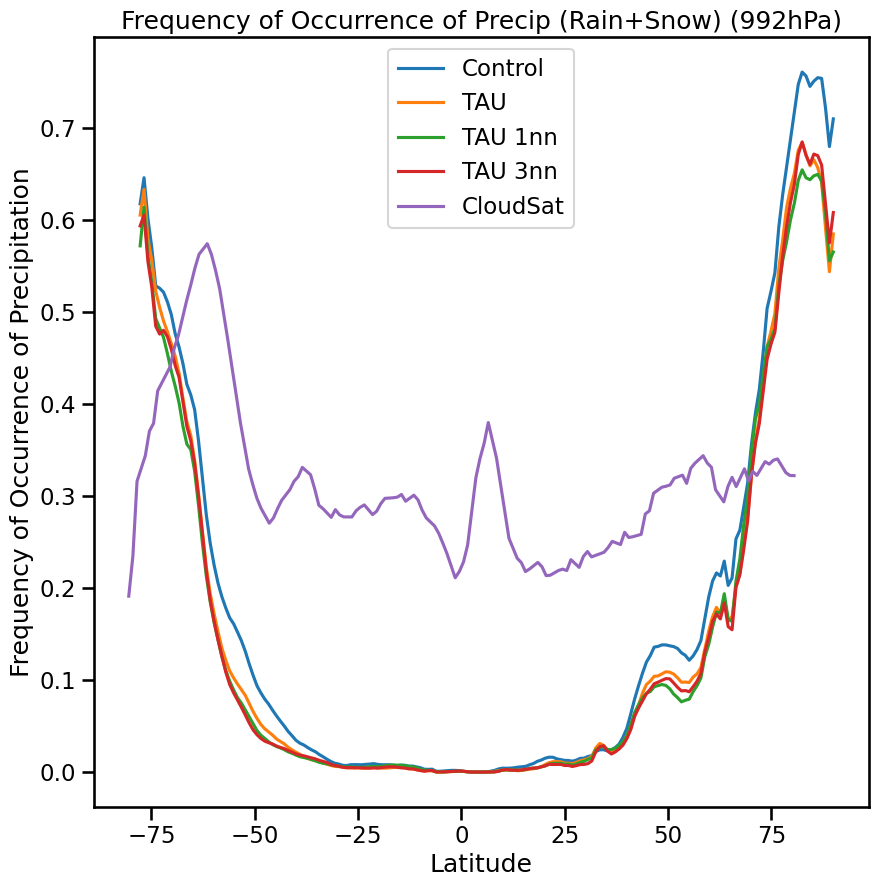

In [75]:
savfig=False
sns.set_context("talk")

for r in range(nr):
    if r==0:
        dl=xr.open_mfdataset(fspec[r],combine='by_coords')
        
    d1=xr.open_mfdataset(fspec[r],combine='by_coords')
    d2=xr.open_mfdataset(fspec[r],combine='by_coords')
    tmp=d1['FREQR'].isel(lev=31)+d2['FREQS'].isel(lev=31)
    freqr=tmp.where(dl.LANDFRAC < 0.1).mean(dim=['time','lon'])
    freqr.plot(label=cstxt[r])
    
plt.plot(dcs.latitude,zmrr,label='CloudSat')
plt.legend()
plt.title('Frequency of Occurrence of Precip (Rain+Snow) (992hPa)')
plt.xlabel('Latitude')
plt.ylabel('Frequency of Occurrence of Precipitation')
if savfig:
    plt.savefig('./figs/TAU-ML5'+'_zmFREQR992_nncompare_rerun2.pdf')
#del cases,ftyp,tmp,fspec,nr

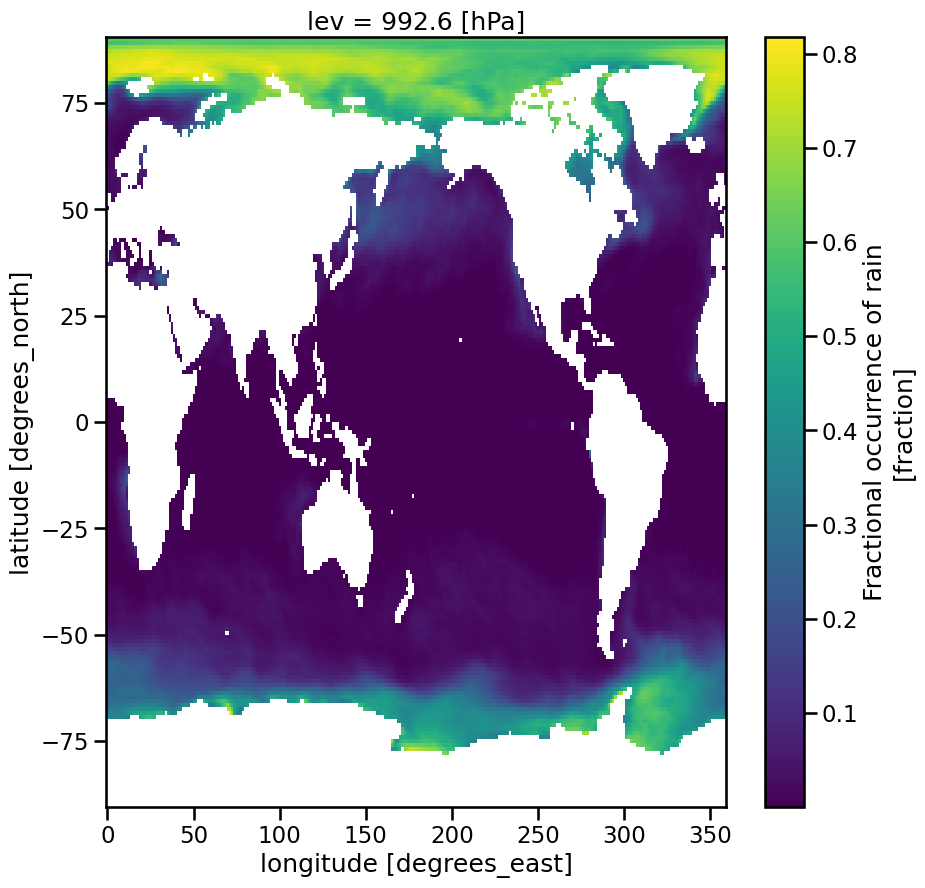

In [76]:
tmp.where(dl.LANDFRAC < 0.1).mean(dim=['time']).plot()
#tmp

### New Cloudsat Array

In [77]:
#Make a new CloudSat array with a lat,lon variable...

tmp=dcs.precip_rate_frequency.values

#lon2=((dcs.longitude.values + 180.) % 360.) - 180.

csnew = xr.DataArray(dcs.precip_rate_frequency.values,[('lon', dcs.longitude.values+180.),('lat', dcs.latitude.values)])

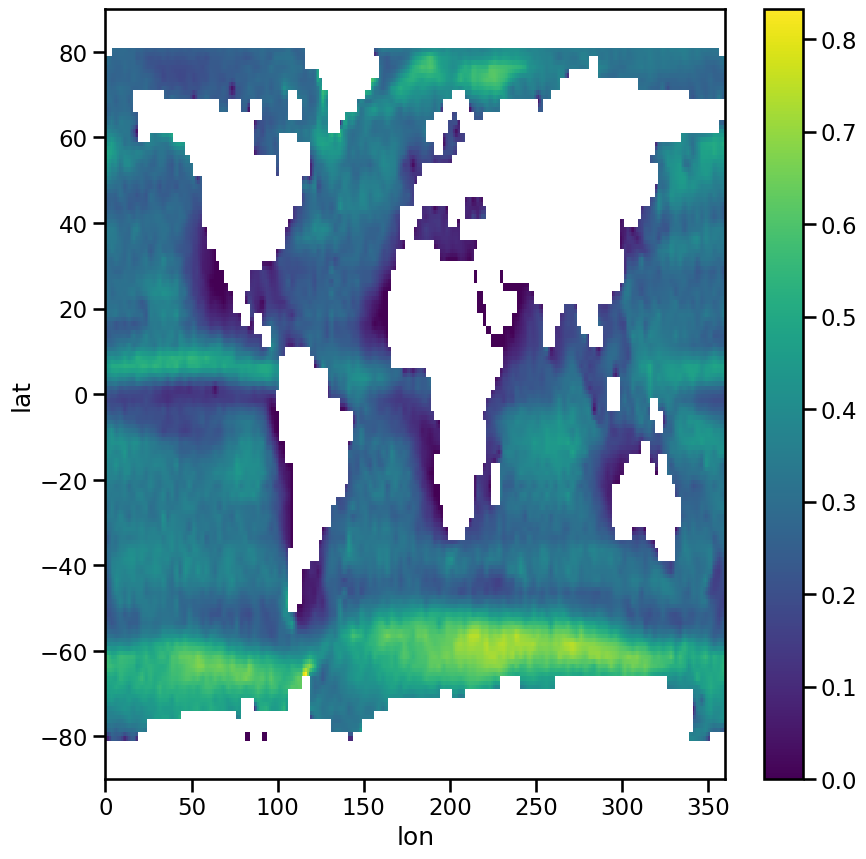

In [78]:
csnew.transpose().plot()

### Read in Precipitation data from Simulations
* make an array for counts
* loop
 * read data
 * loop for time
  * make a new grid for the cloudsat data so can do an 'interp like'
  * Then add to counts for each point > threshold
 * Divide by total times to get freq by lat and lon


In [79]:
#landfraction
dl=xr.open_mfdataset('/glade/derecho/scratch/wchuang/archive/run12_kk2000_12month_rerun/atm/hist/*h0*',combine='by_coords')
landfrac=dl.LANDFRAC.isel(time=0)
#landfrac

In [80]:
# Model data

pth='/glade/derecho/scratch/wchuang/archive/'

cases=['run12_kk2000_12month_rerun',
       'run12_tau_12month_rerun2',
       'run12_1nn_optimized_12month_rerun2',
       'run12_3nn_add_CLD_lev_FREQR_12month_proper_rerun',
      ]

ftyp='*h1*'

cstxt=['Control',
       'TAU',
       'TAU 1nn',
       'TAU 3nn',
      ]

tmp = [pth + s for s in cases]
fspec = [s + '/atm/hist/'+ftyp for s in tmp]
# 
nr=len(cases)
#fspec[0]
#print(fspec[r]+'*.SWCF.*')

In [81]:
fspec[0]
#d1= xr.open_dataset('/glade/scratch/andrew/archive/cam600_base_AE2/atm/hist/cc_cam600_base_AE2.h0.FICE.nc')

'/glade/derecho/scratch/wchuang/archive/run12_kk2000_12month_rerun/atm/hist/*h1*'

In [82]:
#Select variable
varn='PRECT'
scl = 86400.*1000.  # m/s --> mm/d
# mm/hr * hr/d = mm/d
vunits='mm/d'
minpr= 0.01*24./ (100/1.7)
# fsuff='.h1.'+varn+'.nc'
# fsuff2='.h1.PRECC.nc'
minpr

0.004079999999999999

In [83]:
#landfraction on csgrid
newland=landfrac.interp_like(csnew)
# Broadcast it across times....
#bigland = newland.expand_dims({"time": 12}).assign_coords({'time': dl.time})
#bigland.isel(time=11).plot()
newland
tmp=np.where(newland < 0.1)

In [84]:
# Set up big arrays

In [85]:
# New counts array (nr,nxc,nyc): doo on the fly...
fcoord={'runs':cstxt,'lon':csnew.lon,'lat':csnew.lat}
nyc=len(csnew.lat)
nxc=len(csnew.lon)
freqall = xr.DataArray(np.zeros((nr,nyc,nxc)),dims=('runs','lat','lon'),coords=fcoord)
freqlg = xr.DataArray(np.zeros((nr,nyc,nxc)),dims=('runs','lat','lon'),coords=fcoord)

#Don't interpolate....
ny=len(dl.lat)
nx=len(dl.lon)
cgfcoord={'runs':cstxt,'lon':dl.lon,'lat':dl.lat}
cgfreqall = xr.DataArray(np.zeros((nr,ny,nx)),dims=('runs','lat','lon'),coords=cgfcoord)
cgfreqlg = xr.DataArray(np.zeros((nr,ny,nx)),dims=('runs','lat','lon'),coords=cgfcoord)

Read Data

In [86]:
fn

'/glade/derecho/scratch/wchuang/archive/run12_3nn_add_CLD_lev_FREQR_12month_proper_rerun/atm/hist/*h1*'

In [87]:
for r in range(nr):

    #Read Model Data for needed fields....(extract variable first)

    fn=fspec[r]#+'cc_'+cases[r]+fsuff
    d1= xr.open_mfdataset(fn)

    fi=d1[varn]*scl
    fi.attrs['units']=vunits
    
#Subtract convective to get large scale if desired.     

    # fn2=fspec[r]+'cc_'+cases[r]+fsuff2
    # d2= xr.open_dataset(fn2)
    # fil=d1[varn]*scl - d2['PRECC']*scl
    fil=d1[varn]*scl - d1['PRECC']*scl
    
    fi.attrs['units']=vunits

    nt=len(fi.time)
    
# Make a big landfraction grid...
#    bigland = newland.expand_dims({"time": nt}).assign_coords({'time': fi.time})

# Core goes here
# Interp to cloudsat grid
    new=fi.interp_like(csnew)
# Only keep values > threshold (where) and count them over time...
#    new2=new.where(bigland < 0.1)
    cnts=new.where(new > minpr).count(dim='time')

#    freqall[r,:,:]=cnts/float(nt)  #All points (no land fraction sort)
#Now mask for landfraction..
    tmp=cnts/float(nt)
    freqall[r,:,:]=tmp.where(newland < 0.1)

    del cnts,new,tmp

# Now do it again for large scale (fil)
    newl=fil.interp_like(csnew)
#    newl2=newl.where(bigland < 0.1)
    cnts=newl.where(newl > minpr).count(dim='time')
    tmp=cnts/float(nt)
    freqlg[r,:,:]=tmp.where(newland < 0.1)
    del cnts,d1,newl,tmp

    
# Do this again without interpolation....
    cgcnts=fi.where(fi > minpr).count(dim='time')
    tmp=cgcnts/float(nt)
    cgfreqall[r,:,:]=tmp.where(landfrac < 0.1)    
    del tmp,cgcnts,fi
    cgcnts=fil.where(fil > minpr).count(dim='time')
    tmp=cgcnts/float(nt)
    cgfreqlg[r,:,:]=tmp.where(landfrac < 0.1)
    del tmp,cgcnts,fil,nt
    

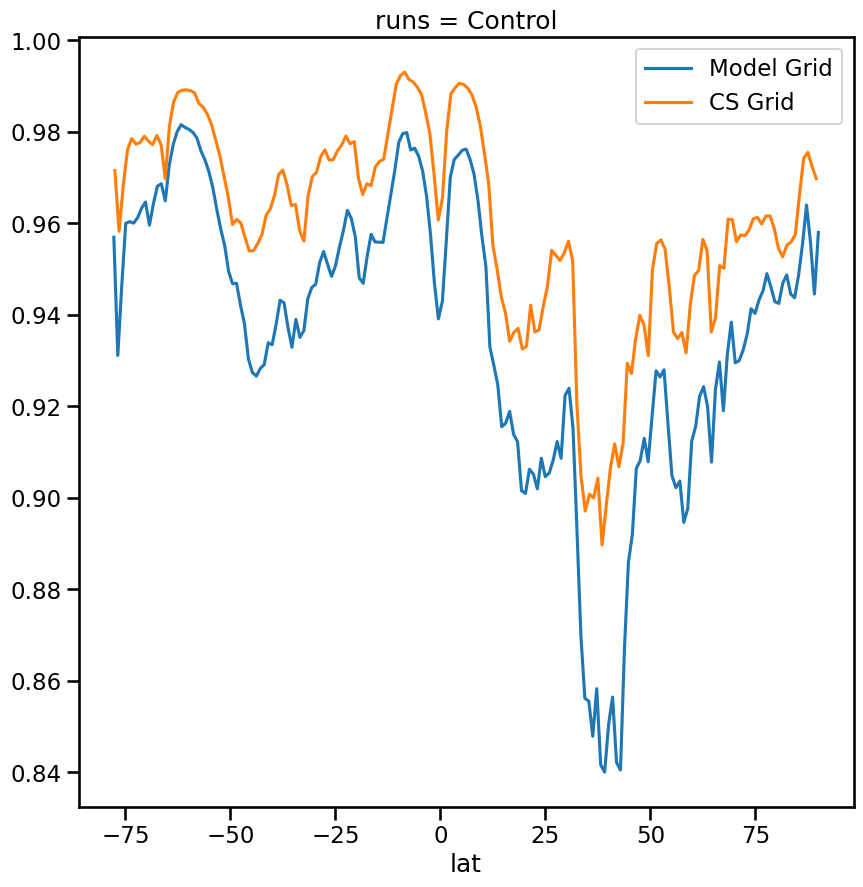

In [88]:
cgfreqall.isel(runs=0).mean(dim='lon').plot(label='Model Grid')
freqall.isel(runs=0).mean(dim='lon').plot(label='CS Grid')
plt.legend()

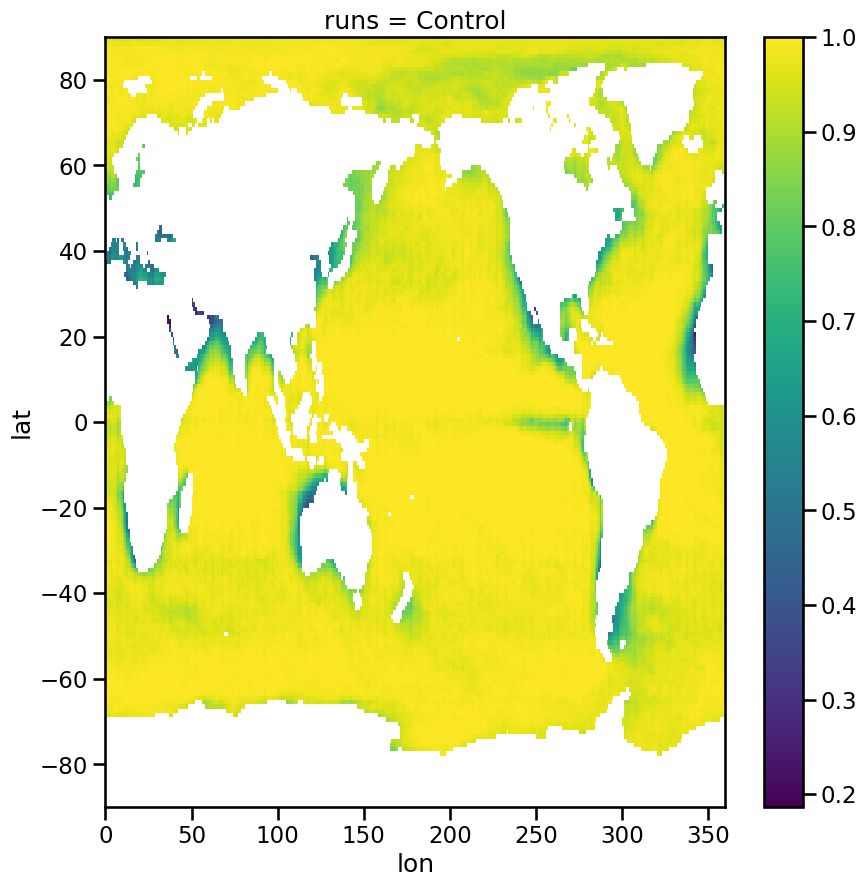

In [89]:
freqall.isel(runs=0).plot()

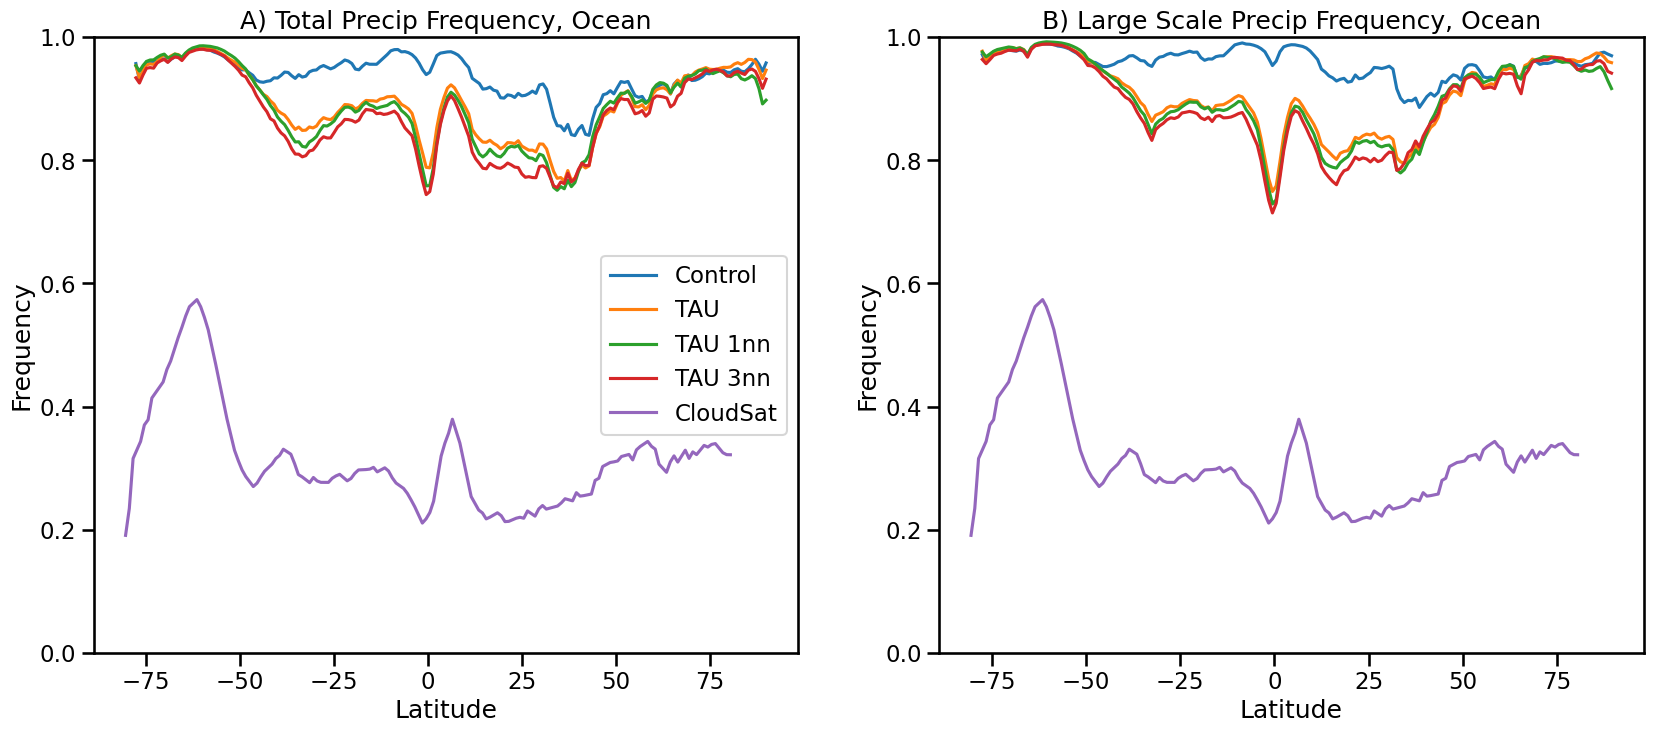

In [90]:
savfig=False
sns.set_context("talk")

fig,axs=plt.subplots(1,2,figsize=(20, 8))

zmf=freqall.mean(dim='lon')
zmfl=freqlg.mean(dim='lon')

cgzmf=cgfreqall.mean(dim='lon')
cgzmfl=cgfreqlg.mean(dim='lon')


for r in range(nr):
    axs[0].plot(cgzmf.lat,cgzmf[r,:],label=cstxt[r])
#axs[0].legend()
axs[0].plot(dcs.latitude,zmrr,label='CloudSat')
axs[0].set_title('A) Total Precip Frequency, Ocean')
axs[0].set_xlabel('Latitude')
axs[0].set_ylabel('Frequency')

#for r in range(nr):
#    axs[0].plot(cgzmf.lat,cgzmf[r,:],label=cstxt[r],linestyle=':')

for r in range(nr):
    axs[1].plot(zmfl.lat,zmfl[r,:],label=cstxt[r])
    
axs[1].plot(dcs.latitude,zmrr,label='CloudSat')
axs[1].set_title('B) Large Scale Precip Frequency, Ocean')
axs[1].set_xlabel('Latitude')
axs[1].set_ylabel('Frequency')
axs[0].legend()

axs[0].set_ylim([0,1.0])
axs[1].set_ylim([0,1.0])
#for r in range(nr):
#    axs[1].plot(cgzmfl.lat,cgzmfl[r,:],label=cstxt[r],linestyle=':')

if savfig:
    plt.savefig('./figs/zmfreq4new2_0.004mmd_nncompare_rerun2.pdf')

In [91]:
#Testing
#should be able to do a where on the 3-d array, 
##gg=np.where(new > thrsh)
##runcounts[gg]=1. #(Does not work)
## or set to NA below threshold then do xarray.count across time dimension....
#new2=new.where(new > minpr)
#cnts=new2.count(dim='time')
#freq=cnts/float(nt)
#zmfreq2=freq.mean(dim='lon')
#freq.plot()

In [92]:
#Should high lats be 1? 

In [93]:
#note, could probably calc counts for each run,maybe even interp across all times at once faster.... then can just get counts all times, sum over time...Faster?
#loop for runs...
#for r in range(nr):
#loop for time
#    for t in range(nt):
#make a new grid for the cloudsat data so can do an 'interp like'
#        new=fiall[r,t,:,:].interp_like(csnew)
#Then add to counts for each point > threshold
#        good array = 1 where new > threshold
#        counts[r,:,:]=counts[r,:,;]+good

#Divide by total times to get freq by lat and lon
#counts=counts/float(nt)